**building ID and probability to Christina**

Only consider first arrival time

Arrival time: calc vs actual

# File Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
pd.options.mode.chained_assignment = None
import datetime
from matplotlib.lines import Line2D
from IPython import embed
import folium
from shapely.geometry import Point
import geopandas as gpd
from folium.plugins import MarkerCluster
import pickle

# Load data

In [2]:
# Load data already merged with fenz data
df_merge_with_fenz = pd.read_csv('shannon_data_residential 2.csv')
df_merge_with_fenz.columns = [x.strip('.x') for x in list(df_merge_with_fenz)]
# only consider callouts which happen on about the same timeframe as is given in the all nz building callout time calculation
df_merge_with_fenz = df_merge_with_fenz[df_merge_with_fenz['First_Arrival_Mins']<30]

# load all of nz building data with sa1 codes already attached
df_new_zealand = pd.read_csv('buildings_complete_dataset.csv') # Buildings_AllNZ_AllColumns_SA1

# Correct added column names to match the merge with fenz data
df_new_zealand = df_new_zealand.rename(columns={'NEAR_DIST':'GNS_Neighb_Dist','travel_time_secs':'First_Arrival_Mins'})
df_new_zealand.drop('OBJECTID',axis=1,inplace=True)
df_new_zealand['First_Arrival_Mins'] = df_new_zealand['First_Arrival_Mins']/60
df_oid = df_new_zealand[['Outline_id','x_coord','y_coord']].set_index(['Outline_id'])

# load census data
df_dwelling1 = pd.read_csv('Census/census_dwelling1.csv')
df_dwelling2 = pd.read_csv('Census/census_dwelling2.csv')
df_dwelling1.rename(columns={'SA1':'sa1'},inplace=True)
df_dwelling2.rename(columns={'SA1':'sa1'},inplace=True)

df_household = pd.read_csv('Census/census_household.csv')
df_individual1 = pd.read_csv('Census/census_individual_1.csv')
df_individual2a = pd.read_csv('Census/census_individual_2a.csv')
df_individual2b = pd.read_csv('Census/census_individual_2b.csv')
df_individual2c = pd.read_csv('Census/census_individual_2c.csv')
df_individual3a = pd.read_csv('Census/census_individual_3a.csv')
df_individual3b = pd.read_csv('Census/census_individual_3b.csv')

df_list = [df_dwelling1, df_dwelling2, df_household, df_individual1, df_individual2a,
           df_individual2b, df_individual2c, df_individual3a, df_individual3b]

del df_dwelling1
del df_dwelling2
del df_household
del df_individual1
del df_individual2a
del df_individual2b
del df_individual2c
del df_individual3a
del df_individual3b

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Preproessing of census and all NZ building data 

Data needs to be in the same form as the data already joined to FENZ data for the model pipeline

In [3]:
def merge_dataframes_on_index(list_of_census_dfs):
    """
    Merge a list of pandas DataFrames by joining on their index.
    
    Parameters:
    df_list (list of pandas DataFrames): List of pandas DataFrames to be merged.
    
    Returns:
    merged_df (pandas DataFrame): Merged DataFrame.
    """
    list_of_census_dfs = [x[~x.sa1.isna()] for x in list_of_census_dfs]
    list_of_census_dfs = [x.set_index('sa1') for x in list_of_census_dfs]
    
    if not list_of_census_dfs:
        return None
    
    # Check if all DataFrames have unique indices
    indices = [df.index.is_unique for df in list_of_census_dfs]
    if not all(indices):
        raise ValueError("All DataFrames must have unique indices.")
    
    # Merge DataFrames
    merged_df = pd.concat(list_of_census_dfs, axis=1)
    
    return(merged_df)

In [4]:
def merging_and_cleaning_datasets(list_of_census_dfs,df_gns):
    df_gns_cp = df_gns.copy()
    
    df_census_data = merge_dataframes_on_index(list_of_census_dfs)
    
    df_census_data.index.names = ['SA12018_V1']
    df_gns_cp.set_index('sa1Codes',inplace=True)
    df_gns_cp.index.names = ['SA12018_V1']
    
    df_gns_cp.rename(columns={
        'Outline_id':'OID_',
        "Use_Category":"GNS_Use_Category",
        "Construction_Type":"GNS_Construction_Type_1",
        "Age":"GNS_Age",
        "Storeys":"GNS_Storeys",
        "Floor_Area":"GNS_Floor_Area",
        "Site_Cover":"GNS_Site_Cover",
        "Roof_Const":"GNS_Roof_Const",
        "Wall_Const":"GNS_Wall_Const",
        "Floor_Height":"GNS_Floor_Hgt",
        "Roof_Pitch":"GNS_Roof_Pitch",
        "Parapet":"GNS_Parapet",
        "Rep_Cost":"GNS_Rep_Cost",
        "Rep_Cost_multi":"GNS_Rep_Cost_multi",
        "Units":"GNS_Num_Units",
        "Res_Units":"GNS_Res_Units",
        "NonRes_Units":"GNS_NonRes_Units",
        "Assign_type":"GNS_Assign_type",
        "Building_dist":"GNS_Building_dist",
        "Neighbour_dist":"GNS_Neighb_Dist"
    },inplace=True)
    df_gns_cp = df_gns_cp.drop(['Point_id','Point_id','x_coord','y_coord','UseCat_code','ConType_code','Roof_code','Wall_code','RoofPitch_code','Parapet_code','Assign_code'],axis=1)
    df_joined = df_gns_cp.join(df_census_data)
    
    df_joined = df_joined.reset_index()
    
    return(df_joined)


In [5]:
df_joined = merging_and_cleaning_datasets(df_list,df_new_zealand)

# remove all columns which are not in the combined fenz data (there are some gns variables which get dropped here?)
df_joined = df_joined[[x for x in list(df_joined) if x in list(df_merge_with_fenz)]]
del df_new_zealand
del df_list

In [6]:
np.mean(df_merge_with_fenz['First_Arrival_Mins'])

7.705382222578257

In [7]:
(df_merge_with_fenz['First_Arrival_Mins']).quantile(0.25)

5.37

In [8]:
(df_merge_with_fenz['First_Arrival_Mins']).quantile(0.75)

8.78

In [9]:
(df_merge_with_fenz['First_Arrival_Mins']).quantile(0.9999)

29.88

In [10]:
np.mean(df_joined['First_Arrival_Mins'])/60

0.07452266206062506

In [11]:
(df_joined['First_Arrival_Mins']).quantile(0.25)

2.446958817358365

In [12]:
(df_joined['First_Arrival_Mins']).quantile(0.9999)

30.0

In [13]:
(df_joined['First_Arrival_Mins']).quantile(0.999)

29.254817602681037

(array([43653., 17990.,  2350.,   576.,   198.,   122.,    50.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 <BarContainer object of 19 artists>)

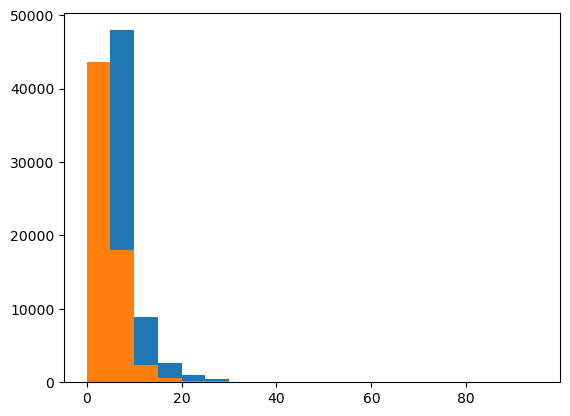

In [14]:
plt.hist(df_merge_with_fenz['First_Arrival_Mins'],bins=np.arange(0,100,5))

plt.hist((df_joined['First_Arrival_Mins']).sample(len(df_merge_with_fenz)),bins=np.arange(0,100,5))

# Setup Model Pipeline

In [15]:
def combine_cols(df,label):
    cols = [x for x in df if label in x]
    most_likely = df[cols].idxmax(axis=1)
    most_likely = [x.strip(label) for x in most_likely]
    most_likely = [x.replace('P','') for x in most_likely]
    most_likely = [x.replace('plus','') for x in most_likely]
    most_likely = [float(x) for x in most_likely]
    df[f'most_likely_{label}'] = most_likely
    df.drop(cols,axis=1,inplace=True)
    return(df)

In [16]:
def processing_data(df_processed_data):
    
    # removing minutes for now because no way to use in risk rating
    if 'Date_Time' in list(df_processed_data):
        df_processed_data['date'] = [x.split(' ')[0] for x in df_processed_data['Date_Time']]
        df_processed_data['date_count'] = [(datetime.datetime(int(x.split('/')[2]),int(x.split('/')[1]),int(x.split('/')[0]))-datetime.datetime(2003,1,1)).days for x in df_processed_data.date]
        # df_processed_data['minutes'] = [int(x.split(':')[0])*60+int(x.split(':')[1]) for x in df_processed_data['time']]
        # df_processed_data['time'] = [x.split(' ')[1] for x in df_processed_data['Date_Time']]
        df_processed_data.drop(['Date_Time','date'],axis=1,inplace=True)
    else: # this is the all of nz data case, where there is no date from fenz
        df_processed_data['date_count'] = (datetime.datetime.today()-datetime.datetime(2003,1,1)).days
    
    
    # Split categorical and numeric variables
    numeric_vars = [x for x in list(df_processed_data) if type(df_processed_data.loc[0,x])!=type('str')]
    categorical_vars = [x for x in list(df_processed_data) if (type(df_processed_data.loc[0,x])==type('str'))&('Date_Time' not in x)]
    
    # convert categorical variables to one-hot-encoded variables (binary)
    df_one_hot_encoded = pd.get_dummies(df_processed_data[categorical_vars])

    # get just numeric variables
    df_numeric = df_processed_data[numeric_vars]
    df_numeric = df_numeric.astype(float)

    # Add back the one-hot-encoded categorical variables
    df_numeric = df_numeric.join(df_one_hot_encoded)

    # First, remove columns which have a significant portion of NAs (we're saying more than 1000
    na_count = df_numeric.isna().sum().sort_values(ascending=True)
    
    # we're going to filter out nans for the analysis. OID and arrival has lots of nans. Will exclude OID from independent variables list, but want to keep it in the data frame so that we have a way of matching the coordiantes back in. We want arrival time because of it's predictive capability
    arrival = df_numeric['First_Arrival_Mins']
    OID = df_numeric['OID_']
    df_numeric = df_numeric[[x for x in list(df_numeric) if (x not in list(na_count[na_count>11000].index))&((x!='OID_')|(x!='First_Arrival_mins'))]]
    df_numeric['OID_'] = OID # put oid back
    if 'First_Arrival_Mins' not in list(df_numeric):
        df_numeric['First_Arrival_Mins'] = arrival # put arrival back
    
    # Now for all the remaining nans, remove the rows
    df_numeric = df_numeric.dropna()

    # combine some variabels to reduce the number of features
    df_numeric = combine_cols(df_numeric,'Rooms.')
    df_numeric = combine_cols(df_numeric,'Beds.')    
    # df_numeric = combine_cols(df_numeric,'noVehc.') # too many nans
    df_numeric = combine_cols(df_numeric,'children.')

    label = 'yrs_at_res.'
    df_numeric.rename(columns={'yrs_at_res.30more':'yrs_at_res.30'},inplace=True) 
    cols = [x for x in df_numeric if label in x]
    most_likely = df_numeric[cols].idxmax(axis=1)
    most_likely = [x.strip(label) for x in most_likely]
    most_likely = [np.mean([float(y) for y in x.split('_')]) for x in most_likely]
    df_numeric[f'most_likely_{label}'] = most_likely
    df_numeric.drop(cols,axis=1,inplace=True)

    label = 'income.'
    df_numeric.rename(columns={'income.less5K':'income.5K',},inplace=True) 
    cols = [x for x in df_numeric if (label in x)&('K' in x)]
    most_likely = df_numeric[cols].idxmax(axis=1)
    most_likely = [x.strip(label) for x in most_likely]
    most_likely = [x.replace('K','').replace('P','') for x in most_likely]
    most_likely = [np.mean([float(y) for y in x.split('_')]) for x in most_likely]
    df_numeric[f'most_likely_{label}'] = most_likely
    df_numeric.drop(cols,axis=1,inplace=True)

    label = 'hrsEmploy.'
    df_numeric.rename(columns={'hrsEmploy.60more':'hrsEmploy.60'},inplace=True) 
    cols = [x for x in df_numeric if (label in x)]
    most_likely = df_numeric[cols].idxmax(axis=1)
    most_likely = [x.strip(label) for x in most_likely]
    most_likely = [np.mean([float(y) for y in x.split('_')]) for x in most_likely]
    df_numeric[f'most_likely_{label}'] = most_likely
    df_numeric.drop(cols,axis=1,inplace=True)

    df_numeric['earning_not_from_work'] = df_numeric['income.ACC']+df_numeric['income.supported']+df_numeric['income.jobSeeker']+df_numeric['income.soleParent']+df_numeric['income.otherBen']
    df_numeric['combined_not_working'] = df_numeric['employed.notInLF']+df_numeric['employed.Unemployed']
    df_numeric['earning_from_work'] = df_numeric['income.salary']+df_numeric['income.selfEmp']
    df_numeric['studying'] = df_numeric['study.fullTime']+df_numeric['study.partTime']
    df_numeric['diffCom.atleastSome'] = df_numeric['diffCom.some']+df_numeric['diffCom.aLot']+df_numeric['diffCom.cannot']
    df_numeric['diffWalk.atleastSome'] = df_numeric['diffWalk.some']+df_numeric['diffWalk.aLot']+df_numeric['diffWalk.cannot']
    df_numeric['homeOwn.OwnOrTrust'] = df_numeric['homeOwn.trust']+df_numeric['homeOwn.own']

    cols = [x for x in list(df_numeric) if 'damp' in x]
    numeric_damp = []
    for row in df_numeric[cols].idxmax(axis=1):
        if row=='damp.no':
            numeric_damp.append(0)
        elif row=='damp.sometimes':
            numeric_damp.append(1)
        elif row=='damp.always':
            numeric_damp.append(2)
        else:
            asdf
    df_numeric['dampness'] = numeric_damp

    # removing columns we don't want to model as per discussion with Christina
    heat_source_cols = [x for x in df_numeric if "Heat_Source" in x]
    fire_source_cols = [x for x in df_numeric if "Fire_Cause" in x]
    mould_cols = [x for x in df_numeric if 'mould' in x]
    fuel_cols = [x for x in df_numeric if 'fuel' in x]
    smoking_cols = [x for x in df_numeric if ('smoking' in x)&('regular' not in x)]
    dwelling_cols = [x for x in df_numeric if 'dwelling' in x]
    prev_residence_cols = [x for x in list(df_numeric) if ('res_5yrs_prev' in x)&('same' not in x)]
    employed_cols = [x for x in list(df_numeric) if ('employed' in x)]
    income_cols =  ['income.ACC','income.supported','income.jobSeeker','income.soleParent','income.otherBen','income.salary','income.selfEmp']
    damp_cols =  ['damp.no','damp.sometimes','damp.always']
    gns_use = [x for x in list(df_numeric) if 'GNS_Use_Category' in x]
    temp_remove = ['Percent_Not_Saved','Damage_m2']
    comp_of_casualties = ['Injury_Count','Fatality_Count']
    always_zero_variables = ['GNS_Use_Category_Appurtenant','GNS_Use_Category_Forestry, Mining','GNS_Roof_Const_Roughcast,etc']
    others_to_remove = ['MB2020_V2_','SA12018_V1','occupied','ResAway','nonPartnered','born.overseas','study.fullTime','study.partTime',
                         'HSCert','HSDip','homeOwn.trust','homeOwn.own','diffCom.some','diffCom.aLot','diffCom.cannot','diffWalk.some','diffWalk.aLot','diffWalk.cannot',
                        'age.30_64','age.15_29'] # removed OID_ from here

    removal_list = heat_source_cols+fire_source_cols+mould_cols+fuel_cols+smoking_cols+dwelling_cols+prev_residence_cols+employed_cols+income_cols+others_to_remove+damp_cols+gns_use+temp_remove+comp_of_casualties+always_zero_variables

    df_numeric = df_numeric[[x for x in list(df_numeric) if x not in removal_list]]
    
    ###################
    # ADDITIONAL DELETES 
    ###################
    too_many_nan_delete = [x for x in df_numeric if 'noVehc.' in x]
    df_numeric.drop(too_many_nan_delete,axis=1,inplace=True)
    df_numeric = df_numeric[[x for x in list(df_numeric) if x not in ['Second_Arrival_Mins']]] #'GNS_Neighb_Dist','First_Arrival_Mins', 
    add_delete = ['NZDep2018', 'yearsInNZ.20years', 'occupation.manager', 'occupation.profess', 'occupation.trade', 'occupation.community', 'occupation.clerical', 'occupation.sales', 'occupation.machinery', 'occupation.labourer', 'landlord.private', 'rent.median', 'tele.no', 'tele.land']
    df_numeric = df_numeric[[x for x in list(df_numeric) if x not in add_delete]]
    
    return(df_numeric)
    


In [17]:
def test_train_split(df_unsplit,target_variable):
    # binarise the target variable for classification algo
    df_unsplit.loc[:,target_variable] = [0 if x<1 else 1 for x in df_unsplit[target_variable]]
    
    independent_variables = [x for x in list(df_unsplit) if x!=target_variable]
    independent_variables.remove('OID_')

    # split into testing and training
    df_training = df_unsplit.sample(int(len(df_unsplit)*0.8))
    df_testing = df_unsplit[~df_unsplit.index.isin(df_training.index)]

    # Normalise the data
    training_mins = np.min(df_training[independent_variables])
    training_maxes = np.max(df_training[independent_variables])

    df_training.loc[:,independent_variables] = (df_training[independent_variables]-training_mins)/(training_maxes-training_mins)
    df_testing.loc[:,independent_variables] = (df_testing[independent_variables]-training_mins)/(training_maxes-training_mins)

    # Adding extra rows which have casualties so that the dataset is approximately equal
    df_training_0 = df_training[df_training[target_variable]==0]
    df_training_gt0 = df_training[df_training[target_variable]>0]
    df_training = df_training_0.append(pd.concat([df_training_gt0]*int(1+len(df_training_0)/len(df_training_gt0))))

    return(df_training,df_testing,independent_variables)

In [18]:
# Train the model
def model_test(mod,df_training,df_testing,independent_variables,target_variable,modname):
    not_for_prediction_list = ['First_Arrival_Mins','Second_Arrival_Mins','date_count','minutes']
    prediction_list = [x for x in independent_variables if x not in not_for_prediction_list]
    
    mod.fit(df_training[independent_variables],df_training[target_variable])
    
    pickle.dump(mod, open(modname, 'wb'))

    predictions = mod.predict(df_testing[independent_variables])
    predictions_proba = mod.predict_proba(df_testing[independent_variables])
    
    df_testing.loc[:,f'{target_variable}_predicted'] = predictions
    df_testing.loc[:,'error'] = df_testing[target_variable]-df_testing[f'{target_variable}_predicted']

    df_testing.loc[:,f'{target_variable}_Probability'] = predictions_proba[:,1] 
    
    actual_vs_predicted_casuality_dict = {}
    for casualty_count,group in df_testing.groupby(target_variable):
        actual_vs_predicted_casuality_dict.update({
            casualty_count:{k:len(v) for k,v in group.groupby(f'{target_variable}_predicted')}
        })

    df_result_summary = pd.DataFrame.from_dict(actual_vs_predicted_casuality_dict,orient='index').fillna(0)
    
    tp = df_result_summary.loc[1,1]
    tn = df_result_summary.loc[0,0]
    fn = df_result_summary.loc[1,0]
    fp = df_result_summary.loc[0,1]

    fscore = 2*tp/(2*tp+fp+fn)

    print('F-score',fscore)
    print('')
    
    print('compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count')
    return(df_result_summary,mod)

# Run Model Pipeline on FENZ data

In [19]:
target_variable = 'Casualty_Count'

df_numeric = processing_data(df_merge_with_fenz)
# del df_merge_with_fenz
df_training,df_testing,independent_variables = test_train_split(df_numeric,target_variable)
del df_numeric
df_result_summary,mod = model_test(GradientBoostingClassifier(),df_training,df_testing,independent_variables,target_variable,'casualty_mod.sav')
df_result_summary

F-score 0.1373145002681924

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


,0,1
0,5472,4550
1,275,384


# Analyse Results

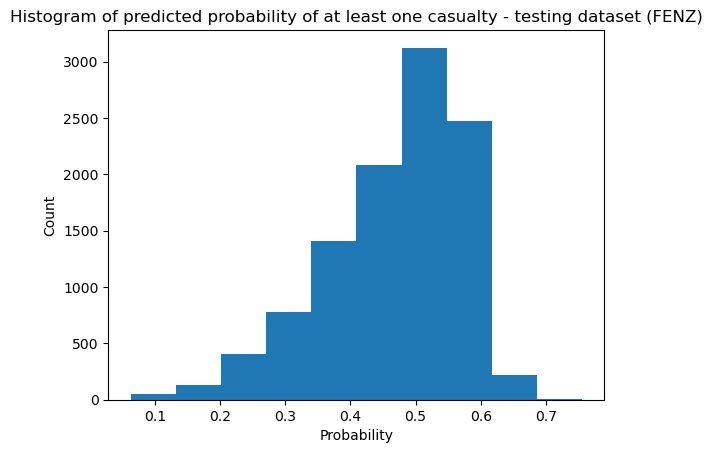

In [20]:
%matplotlib inline
fig,ax = plt.subplots()

ax.hist(df_testing[target_variable+"_Probability"])
ax.set_ylabel('Count')
ax.set_xlabel('Probability')
ax.set_title('Histogram of predicted probability of at least one casualty - testing dataset (FENZ)')

plt.show()

In [21]:
# Split risk categories equally
qb12 = df_testing[target_variable+'_Probability'].quantile(0.3333)
qb23 = df_testing[target_variable+'_Probability'].quantile(0.6667)

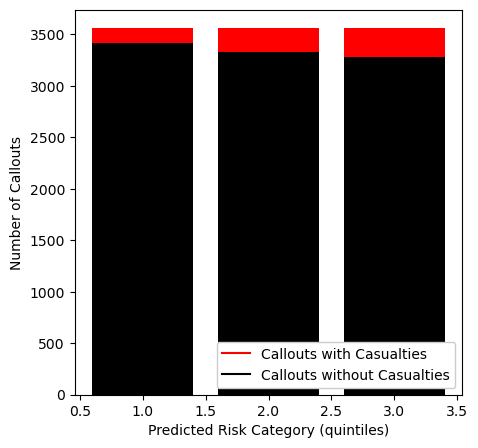

In [22]:
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot2grid((1,1),(0,0))

for q,qlb,qub in zip(np.arange(1,4,1),[0,qb12,qb23],[qb12,qb23,1]):
    ax1.bar(q,len(df_testing[(df_testing['Casualty_Count']==0)&(df_testing[target_variable+'_Probability']>qlb)&(df_testing[target_variable+'_Probability']<qub)]),color='k')
    ax1.bar(q,len(df_testing[(df_testing['Casualty_Count']==1)&(df_testing[target_variable+'_Probability']>qlb)&(df_testing[target_variable+'_Probability']<qub)]),color='r',
            bottom=len(df_testing[(df_testing['Casualty_Count']==0)&(df_testing[target_variable+'_Probability']>qlb)&(df_testing[target_variable+'_Probability']<qub)]))
    
ax1.set_ylabel('Number of Callouts')
ax1.set_xlabel('Predicted Risk Category (quintiles)')
# ax1.set_ylim([0,2250])

casualties = Line2D([],[],c='r')
no_casualties = Line2D([],[],c='k')

legend = plt.legend([casualties,no_casualties],['Callouts with Casualties','Callouts without Casualties'],loc='lower right')
legend.get_frame().set_alpha(None)

In [23]:
df_testing['risk_categories'] = pd.cut(df_testing[f'{target_variable}_Probability'],[0,qb12,qb23,1],labels=np.arange(1,4,1))

In [24]:
df_testing[['Casualty_Count','Casualty_Count_Probability','risk_categories']]

,Casualty_Count,Casualty_Count_Probability,risk_categories
18,0,0.516275,2
22,0,0.306531,1
25,0,0.545948,3
31,0,0.493166,2
40,0,0.337312,1
...,...,...,...
75635,0,0.509263,2
75638,0,0.488692,2
75641,0,0.556485,3
75648,0,0.547595,3


# Run Model Pipeline on all Data

In [25]:
df_numeric_2 = processing_data(df_joined)

In [26]:
predictions_proba = mod.predict_proba(df_numeric_2[independent_variables])

In [27]:
df_numeric_2[f'{target_variable}_Probability'] = predictions_proba[:,1]

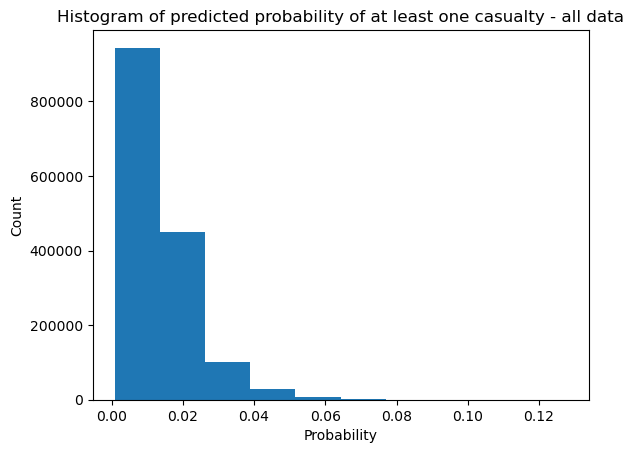

In [28]:
%matplotlib inline
fig,ax = plt.subplots()

ax.hist(df_numeric_2[f'{target_variable}_Probability'])
ax.set_ylabel('Count')
ax.set_xlabel('Probability')
ax.set_title('Histogram of predicted probability of at least one casualty - all data')

plt.show()

In [29]:
np.max(df_numeric_2[f'{target_variable}_Probability'])

0.12755527147818813

In [30]:
df_numeric_2 = df_numeric_2.set_index('OID_')

In [31]:
df_numeric_2 = df_numeric_2.join(df_oid)

In [32]:
df_numeric_2.to_csv('buildings_with_casualty_prob.csv')

# Plot spatially

In [33]:
# Split risk categories equally
qb12 = df_numeric_2[f'{target_variable}_Probability'].quantile(0.3333)#np.max(df_numeric_2['Casualty_Probability'])/3
qb23 = 0.05#np.max(df_numeric_2['Casualty_Probability'])*2/3

df_numeric_2['risk_categories'] = pd.cut(df_numeric_2[f'{target_variable}_Probability'],[0,qb12,qb23,1],labels=np.arange(1,4,1))

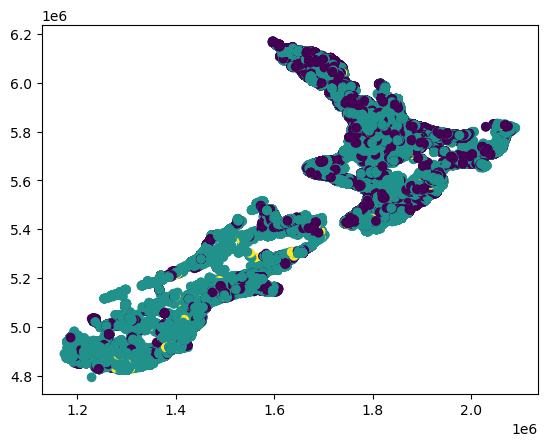

In [34]:
plt.scatter(df_numeric_2.x_coord,df_numeric_2.y_coord,c=df_numeric_2.risk_categories)

In [35]:
df_numeric_2[['x_coord','y_coord']].head(10)

,x_coord,y_coord
1000000.0,1.804359e+06,5.814070e+06
1000001.0,1.804351e+06,5.814088e+06
1000004.0,1.804347e+06,5.814106e+06
1000005.0,1.804278e+06,5.814064e+06
1000007.0,1.804260e+06,5.814072e+06
1000008.0,1.804248e+06,5.814079e+06
1000010.0,1.804215e+06,5.814100e+06
1000011.0,1.804226e+06,5.814100e+06
1000014.0,1.804161e+06,5.814079e+06
1000015.0,1.804158e+06,5.814139e+06


In [36]:
data = {'x_coord': [174.7633, 175.2810, 175.0112],
        'y_coord': [-36.8485, -37.7870, -37.8056]}
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['x_coord'], data['y_coord']))
gdf

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,x_coord,y_coord,geometry
0,174.7633,-36.8485,POINT (174.76330 -36.84850)
1,175.2810,-37.7870,POINT (175.28100 -37.78700)
2,175.0112,-37.8056,POINT (175.01120 -37.80560)


In [37]:
df_numeric_2_colored = df_numeric_2.copy()
df_numeric_2_colored['risk_categories'] = pd.cut(df_numeric_2_colored[f'{target_variable}_Probability'],[0,qb12,qb23,1],labels=['blue','black','red'])

df_numeric_2_sample = df_numeric_2_colored.sample(10000)
geometry = [Point(xy) for xy in zip(df_numeric_2_sample.x_coord, df_numeric_2_sample.y_coord)]
df = df_numeric_2_sample[['risk_categories']].rename(columns={'risk_categories':'color'})
gdf = gpd.GeoDataFrame(df, crs="EPSG:2193", geometry=geometry).to_crs('EPSG:4326')

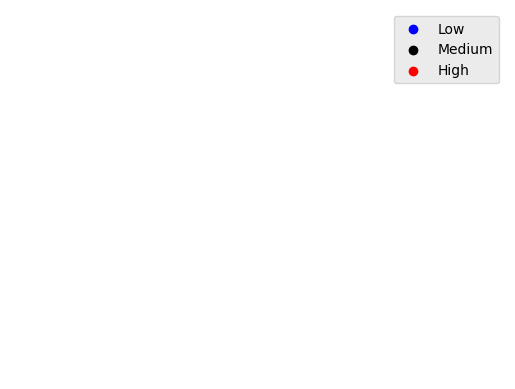

In [38]:
c1 = plt.scatter([],[],c='b')
c2 = plt.scatter([],[],c='k')
c3 = plt.scatter([],[],c='r')


leg = plt.legend([c1,c2,c3],['Low','Medium','High'],facecolor ='0.9')
plt.axis('off')

fig = leg.figure
fig.canvas.draw()

bbox = leg.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

plt.savefig('legend.png',bbox_inches=bbox)

In [39]:
# Assuming gdf is your GeoDataFrame with 'color' column and 'geometry' column containing Point geometries

nz_map = folium.Map(location=[-40.9006, 174.8860], zoom_start=5)

# Create a MarkerCluster layer
marker_cluster = MarkerCluster(disable_clustering_at_zoom=10).add_to(nz_map)

# Add circle markers to the map for each point
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['geometry'].y, row['geometry'].x],  # Reversed order for Folium
        radius=5,  # Adjust marker radius for better visibility
        color=row['color'],  # Set marker border color
        fill=True,
        fill_color=row['color'],  # Set marker fill color
        fill_opacity=0.6,  # Adjust opacity for better visibility
    ).add_to(marker_cluster)
    
    
# Legend 
legend_html = """
<div style="position: fixed; bottom: 15px; right: 1400px; z-index: 1000;width: 100px; height: 66px; background-color: white; border: 1px solid black; text-align: center;">
    <img src="{}" alt="Custom Image Overlay" style="max-width: 100%; max-height: 100%;">
</div>
""".format("legend.png")

nz_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
nz_map.save('nz_map.html')

# # Display the map
# nz_map


# Feature importance

In [40]:
df_feature_importance = pd.DataFrame.from_dict({x:y for x,y in zip(list(independent_variables),mod.feature_importances_)},orient='index').sort_values(0,ascending=False)
print('Top 20 feature importance - all add up to 1.00')
df_feature_importance.head(50)

Top 20 feature importance - all add up to 1.00


,0
woodBurner,0.094354
First_Arrival_Mins,0.063352
date_count,0.047890
GNS_Rep_Cost,0.040120
ethnicGroup.pacific,0.034655
income.interest,0.031105
GNS_Age,0.029755
GNS_Floor_Area,0.027044
GNS_Neighb_Dist,0.023407
portableGasHeater,0.021287


In [41]:
df_feature_importance.tail(50)

,0
GNS_Roof_Pitch_MODERATE (25–40 deg),0.002132
noHeating,0.001910
language.tooYoung,0.001646
born.NZ,0.001512
GNS_Floor_Hgt,0.001379
GNS_Parapet_No Parapet,0.001279
GNS_Wall_Const_Plastic,0.001214
GNS_Construction_Type_1_Brick Masonry,0.001020
language.samoan,0.000968
GNS_Wall_Const_Weatherboard,0.000595


# Model for Building Fire

In [42]:
# travel time should be removed

In [43]:
df_was_fire = processing_data(df_merge_with_fenz)
df_was_fire.drop(['Casualty_Count'],axis=1,inplace=True)
df_all_buildings = processing_data(df_joined)

# This may not be the best thing to do, but drop duplicated buildings (maybe there are some with identical characteristics?)
df_all_buildings = df_all_buildings.drop_duplicates()
df_was_fire = df_was_fire.drop_duplicates()

In [44]:
df_was_fire['was_fire'] = 1
df_all_buildings['was_fire'] = 0

In [45]:
df_with_and_without_fire = pd.concat([df_all_buildings]+[df_was_fire]*int(1+len(df_all_buildings)/len(df_was_fire)))
df_with_and_without_fire = df_with_and_without_fire.drop(['date_count'],axis=1)
# Not sure why there weren't any duplicates (other than my artificial ones) to drop?

In [46]:
target_variable = 'was_fire'
df_training_was_fire,df_testing_was_fire,independent_variables_was_fire = test_train_split(df_with_and_without_fire,target_variable)

In [47]:
mylist = list(df_training_was_fire.T.dropna().T)

In [48]:
[x for x in list(df_training_was_fire) if x not in mylist]

[]

In [49]:

df_result_summary_was_fire,mod_was_fire = model_test(GradientBoostingClassifier(),df_training_was_fire,df_with_and_without_fire,independent_variables_was_fire,target_variable,'was_fire.sav')
df_result_summary_was_fire

F-score 0.6583999211645754

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


,0,1
0,69542,1466797
1,68846,1479899


# Analyse If building fire occurs Results

KeyError: 'was_fire_Probability'

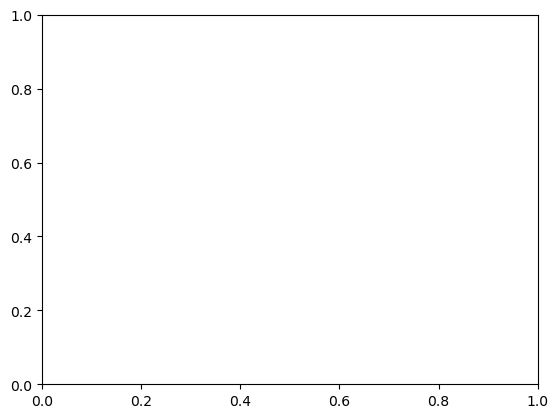

In [50]:
%matplotlib inline
fig,ax = plt.subplots()

ax.hist(df_testing_was_fire['was_fire_Probability'])
ax.set_ylabel('Count')
ax.set_xlabel('Probability')
ax.set_title('Histogram of predicted probability of at least one casualty - testing dataset (FENZ)')

plt.show()